# PyTorch Neural Network Classification

## Architecture of a classification neural network

Before we get into writing code, let's look at the general architecture of a classification neural network.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification |

Of course, this ingredient list of classification neural network components will vary depending on the problem you're working on.

But it's more than enough to get started.

We're going to get hands-on with this setup throughout this notebook.

## Imports

In [1]:
import requests
import numpy as np 
import pandas as pd 
import torch 
import matplotlib.pyplot as plt

from torch import nn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from pathlib import Path 


In [2]:
if Path('helper_function.py').is_file():
    print("File already exist")
else: 
    print('Downloading File')
    file_link = f'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py'
    request = requests.get(file_link)
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

In [3]:
from helper_functions import plot_decision_boundary, plot_predictions

In [4]:
%load_ext autoreload
%autoreload 2 

In [5]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'SEED: {SEED}')
print(f'Device: {device}')
print(f'torch version: {torch.__version__}')

SEED: 42
Device: cuda
torch version: 2.7.0+cu126


## Building Dataset

In [6]:
# Will be using the sklearn.datasets -> make_circles 

# Number of samples 
n_samples = 1000

X, Y = make_circles(
    n_samples= n_samples,
    noise= 0.03, 
    random_state= SEED
)


# sklearn.datasets.make_circles -> gives a 2d circle containing a smaller circle (X:(n_sample, 2), Y:1 or 0)

In [7]:
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

Shape of X: (1000, 2)
Shape of Y: (1000,)


In [8]:
circles = pd.DataFrame({"X1": X[:, 0],
                   "X2": X[:, 1],
                   'Y': Y})

circles.head(10)

,X1,X2,Y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [9]:
circles.Y.value_counts()

Y
1    500
0    500
Name: count, dtype: int64

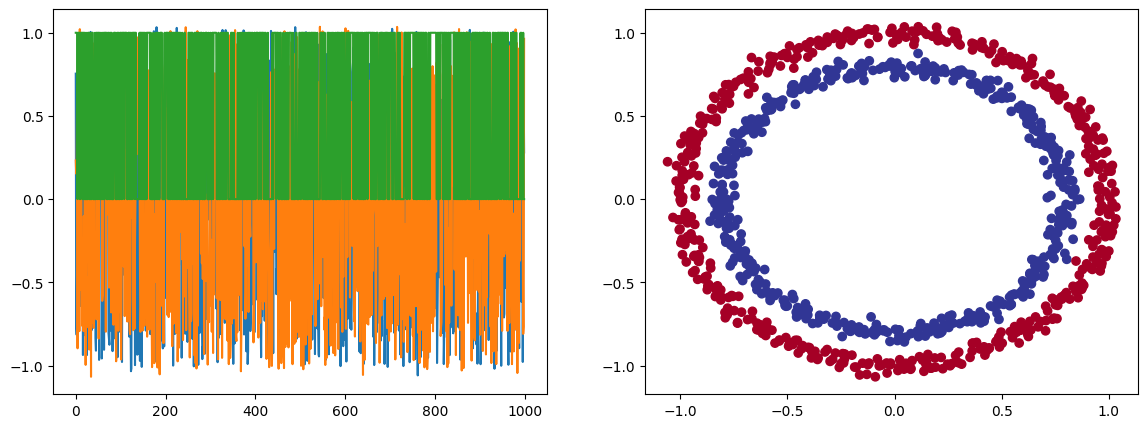

In [10]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(circles)
plt.subplot(1,2,2)
plt.scatter(
    x= X[:, 0],
    y= X[:, 1],
    c=Y,
    cmap=plt.cm.RdYlBu
);

**TASK :** 

Our task is to predict if it a blue dot or the red dot if the given values are for the inner circle or the outer circle

In [11]:
# Changing the data to tensor 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(Y).type(torch.float)

print(f'type: {type(X)}, Dtype: {X.dtype}')

type: <class 'torch.Tensor'>, Dtype: torch.float32


In [12]:
# Splitting the data into train and test 

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size= 0.2, # 20% of the data
    random_state= SEED
)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## Building a Model

1. Setup Device agnostic code
2. Construct a model subclass `nn.Module`
3. Define the loss and optimizer
4. Training loop

In [13]:
print(device)

cuda


In [14]:
class CircleModelV0(nn.Module):
    """
    A simple two-layer feedforward neural network for binary classification.

    This model is designed for datasets with two input features (e.g., x1, x2) and a binary output.
    It consists of two fully connected (linear) layers:
      - Layer 1: Maps 2 input features to 5 hidden units.
      - Layer 2: Maps 5 hidden units to 1 output (for binary classification).

    Example usage:
        model = CircleModelV0()
        output = model(torch.randn(10, 2))  # Forward pass with batch of 10 samples

    Attributes:
        Layer1 (nn.Linear): First linear layer (input: 2, output: 5).
        Layer2 (nn.Linear): Second linear layer (input: 5, output: 1).
    """
    def __init__(self):
        """
        Initializes the CircleModelV0 with two linear layers.
        """
        super().__init__()
        self.Layer1 = nn.Linear(in_features=2, out_features=5)
        self.Layer2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 2).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1).
        """
        self.out = self.Layer2(self.Layer1(x))
        return self.out

In [15]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (Layer1): Linear(in_features=2, out_features=5, bias=True)
  (Layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
print(f"Stuff that is there in model.parameters(): \n{next(model_0.parameters())},\nStuff inside of model.state_dict: \n{model_0.state_dict()}")

Stuff that is there in model.parameters(): 
Parameter containing:
tensor([[ 0.6450,  0.3646],
        [ 0.5513, -0.2975],
        [ 0.0908, -0.5242],
        [-0.5820,  0.5369],
        [-0.4575, -0.2743]], device='cuda:0', requires_grad=True),
Stuff inside of model.state_dict: 
OrderedDict([('Layer1.weight', tensor([[ 0.6450,  0.3646],
        [ 0.5513, -0.2975],
        [ 0.0908, -0.5242],
        [-0.5820,  0.5369],
        [-0.4575, -0.2743]], device='cuda:0')), ('Layer1.bias', tensor([-0.4767,  0.4414,  0.6889,  0.2552, -0.4263], device='cuda:0')), ('Layer2.weight', tensor([[ 0.1200, -0.4007, -0.1733, -0.0542, -0.3408]], device='cuda:0')), ('Layer2.bias', tensor([-0.1584], device='cuda:0'))])


In [17]:
# nn.Sequential(): 
# Modules will be added to it in the order they are passed in the constructor
# The forward() method of Sequential accepts any input and forwards 
# it to the first module it contains. It then “chains” outputs to inputs sequentially 
# for each subsequent module, finally returning the output of the last module.

nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)



Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
X_test.dtype

torch.float32

In [19]:
with torch.inference_mode():
    untrained_pred = model_0(X_test.to(device))

In [20]:
print(f"First 10 prediction made by the model {untrained_pred[:10]}")

First 10 prediction made by the model tensor([[-0.1737],
        [-0.0745],
        [-0.5004],
        [-0.0809],
        [-0.6057],
        [-0.5443],
        [-0.1813],
        [-0.2916],
        [-0.4954],
        [-0.0690]], device='cuda:0')


**🔹 Entropy (Information Theory)**

Entropy is a concept from information theory that quantifies the uncertainty or surprise of a probability distribution.

For a true distribution P, the entropy is:

$$H(P) = -\sum_i P(i) \log P(i)$$

This tells us how “unpredictable” a distribution is. For example:
* A fair coin has high entropy.	
* A biased coin (e.g. 99% heads) has low entropy.	

_______________

**🔹 Cross-Entropy (Loss Function)**

In machine learning, we usually have:
* A true distribution P (e.g. one-hot label).	
* A predicted distribution Q (from the model, e.g. softmax output).	

The cross-entropy between them is:

$$H(P, Q) = -\sum_i P(i) \log Q(i)$$

If P is a one-hot vector (e.g., for class 2 out of 5 classes: P = [0, 0, 1, 0, 0]), this simplifies to:	

$$H(P, Q) = -\log Q(\text{true class})$$

How Entropy Relates to Loss	
* Loss measures how bad a model’s prediction is.	
* Cross-entropy loss penalizes the model more when it assigns low probability to the correct class.	
* Lower cross-entropy → predictions closer to the truth.	
* Higher entropy in predictions → more uncertainty/confusion.	


In [21]:
# We will be using the binary-cross-entropy loss with logits loss 
# so sigmoid - it just give us the probability distribution -> logits 
# why are we using the binary cross-entropy loss - we want to quantify our loss like if we are wrong how much are we wrong 
# secondly if we get a high cross-entropy that means huge amount of uncertainty which is not good 
# if we use something as mean squared in that case it will be wether we predicted correct label or not 
# with cross entropy we have probability for both the class or as many class we have 
# so in this case our model tell us it is 99% sure its the inner circle and 1% sure it outer circle 
# this is necessary as now we have a way to adjust our model to improve its predictions

loss_fn = nn.BCEWithLogitsLoss() # this is with a sigmoid activation 

optim = torch.optim.SGD(params=model_0.parameters(), lr= 0.1)

# Calculate accuracy - out of 100 examples what percentage our models get's correct 
# Accuracy = (True positive / (True positive + True negative) )* 100

# def accuracy_fn(y_true, y_pred):
#     correct = torch.eq(y_true,y_pred).sum().item()
#     acc = (correct / len(y_pred)) * 100
#     return acc

accuracy_fn = lambda y_true, y_pred : (torch.eq(y_true, y_pred).sum().item()/ len(y_pred)) * 100


## Training loop 



In [22]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (Layer1): Linear(in_features=2, out_features=5, bias=True)
  (Layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
epochs = 100
SEEDS = 42

torch.manual_seed(SEEDS)

# Moving everything to device 
X_train , X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()

optim = torch.optim.SGD(params=model_0.parameters(),
                        lr = 0.1)

accuracy_fn = lambda y_true, y_pred: (torch.eq(y_true, y_pred).sum().item()/ len(y_pred)) * 100

# training loop 
for epoch in range(epochs):
    # setting the training mode
    model_0.train()


    y_logits = model_0(X_train).squeeze() # to remove the extra dim it is going to of the shape - [len(x_train), 1]


    y_pred = torch.round(torch.sigmoid(y_logits)) # converting the logits to probability and rounding them up

    loss = loss_fn(y_logits, y_train) 

    acc = accuracy_fn(y_train, y_pred)

    # Set the gradient to zeros
    optim.zero_grad()

    # Backward pass
    loss.backward()

    # stepping up the optimizer to make the changes in the weights and bias 
    optim.step()

    # Evaluation 
    model_0.eval()
    with torch.inference_mode():

        # test loss and accuracy
        y_test_logits = model_0(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))

        loss_test = loss_fn(y_test_logits, y_test)
        test_acc = accuracy_fn(y_test, y_test_pred)
    
    # Printing the observations 
    if epoch % 10 == 0: 
        print(f'Epoch {epoch}: Train => Loss: {loss:.2f}, Accuracy: {acc:.2f} | Test => Loss: {loss_test:.2f}, Accuracy: {test_acc:.2f} ')


Epoch 0: Train => Loss: 0.71, Accuracy: 50.00 | Test => Loss: 0.70, Accuracy: 50.00 
Epoch 10: Train => Loss: 0.70, Accuracy: 40.88 | Test => Loss: 0.69, Accuracy: 42.00 
Epoch 20: Train => Loss: 0.70, Accuracy: 46.12 | Test => Loss: 0.69, Accuracy: 49.50 
Epoch 30: Train => Loss: 0.69, Accuracy: 47.75 | Test => Loss: 0.69, Accuracy: 50.00 
Epoch 40: Train => Loss: 0.69, Accuracy: 48.38 | Test => Loss: 0.69, Accuracy: 51.00 
Epoch 50: Train => Loss: 0.69, Accuracy: 48.62 | Test => Loss: 0.69, Accuracy: 52.00 
Epoch 60: Train => Loss: 0.69, Accuracy: 49.38 | Test => Loss: 0.69, Accuracy: 52.50 
Epoch 70: Train => Loss: 0.69, Accuracy: 49.12 | Test => Loss: 0.69, Accuracy: 54.00 
Epoch 80: Train => Loss: 0.69, Accuracy: 49.00 | Test => Loss: 0.69, Accuracy: 55.00 
Epoch 90: Train => Loss: 0.69, Accuracy: 49.62 | Test => Loss: 0.69, Accuracy: 53.50 


## Fixing the model

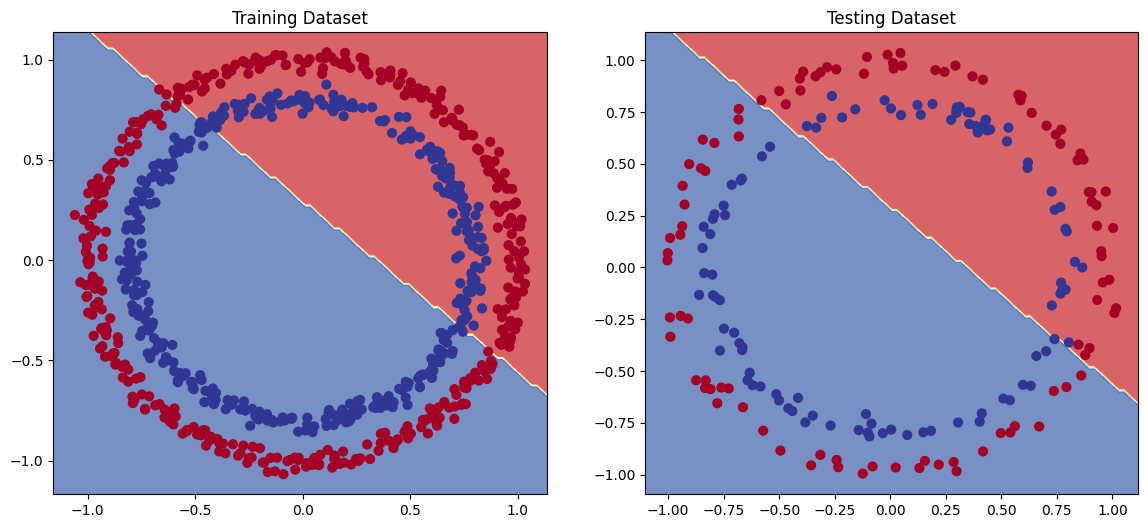

In [24]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.title("Training Dataset")
plot_decision_boundary(model_0, X_train, y_train);
plt.subplot(122)
plt.title("Testing Dataset")
plot_decision_boundary(model_0, X_test, y_test);
plt.show()

In [ ]:
# So in the above plots we can clearly see that our model is not learning the decision boundary correctly and that why it making so wrong predictions 
# the model is trying to split the red and blue dot using straight line 

## Improving the model

1. Adding more Layers
2. Adding more hidden units
3. Fit for longer
4. Changing the activation functions 
5. Changing the loss functions


In [33]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.Layer1 = nn.Linear(in_features=2, out_features=10) # adding more hidden units 
        self.Layer2 = nn.Linear(in_features= 10, out_features=10) # Extra layer
        self.Layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        self.out = self.Layer3(self.Layer2(self.Layer1(x)))
        return self.out

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (Layer1): Linear(in_features=2, out_features=10, bias=True)
  (Layer2): Linear(in_features=10, out_features=10, bias=True)
  (Layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params= model_1.parameters(), lr=0.1)

In [35]:
# Training loop 
epochs = 1000 # Training for longer 

torch.manual_seed(SEED)

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


for epoch in range(epochs):
    # set the model to train mode 
    # pass the data in the forward method 
    # logits to sigmoid to get probs 
    # loss and accuracy 
    # optimizer set to zero_grad
    # backward pass loss.backward()
    # optimizer.step()
    # model.eval() + inference_mode()
    # testing data same stuff 
    # printing the results 

    model_1.train()

    logits = model_1(X_train).squeeze()
    preds = torch.round(torch.sigmoid(logits))

    loss = loss_fn(logits, y_train)
    acc = accuracy_fn(y_train, preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)
    
    if epoch % 100 == 0 : 
        print(f'Epoch {epoch}: Train => Loss: {loss:.2f}, Accuracy: {acc:.2f} | Test => Loss: {test_loss:.2f}, Accuracy: {test_acc:.2f} ')


Epoch 0: Train => Loss: 0.69, Accuracy: 50.88 | Test => Loss: 0.69, Accuracy: 51.00 
Epoch 100: Train => Loss: 0.69, Accuracy: 50.38 | Test => Loss: 0.69, Accuracy: 48.00 


Epoch 200: Train => Loss: 0.69, Accuracy: 51.12 | Test => Loss: 0.69, Accuracy: 46.00 
Epoch 300: Train => Loss: 0.69, Accuracy: 51.62 | Test => Loss: 0.69, Accuracy: 45.00 
Epoch 400: Train => Loss: 0.69, Accuracy: 51.12 | Test => Loss: 0.69, Accuracy: 46.00 
Epoch 500: Train => Loss: 0.69, Accuracy: 51.00 | Test => Loss: 0.69, Accuracy: 46.00 
Epoch 600: Train => Loss: 0.69, Accuracy: 51.00 | Test => Loss: 0.69, Accuracy: 46.00 
Epoch 700: Train => Loss: 0.69, Accuracy: 51.00 | Test => Loss: 0.69, Accuracy: 46.00 
Epoch 800: Train => Loss: 0.69, Accuracy: 51.00 | Test => Loss: 0.69, Accuracy: 46.00 
Epoch 900: Train => Loss: 0.69, Accuracy: 51.00 | Test => Loss: 0.69, Accuracy: 46.00 


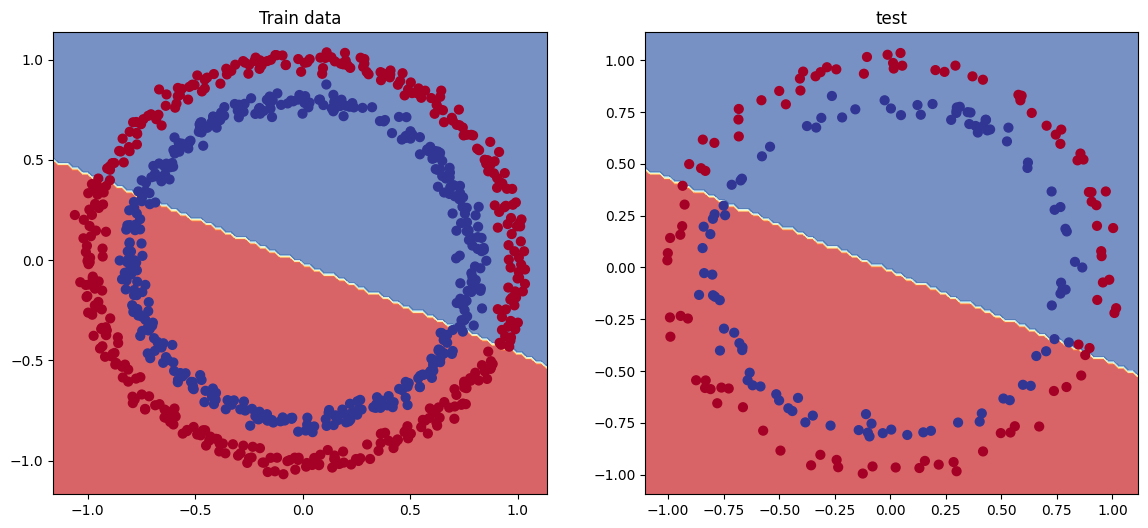

In [36]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_decision_boundary(model_1, X_train, y_train)
plt.title("Train data")
plt.subplot(122)
plot_decision_boundary(model_1, X_test, y_test)
plt.title("test")
plt.show()

Its the same no changes in the loss or accuracy, lets test for some random data 

In [54]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [55]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


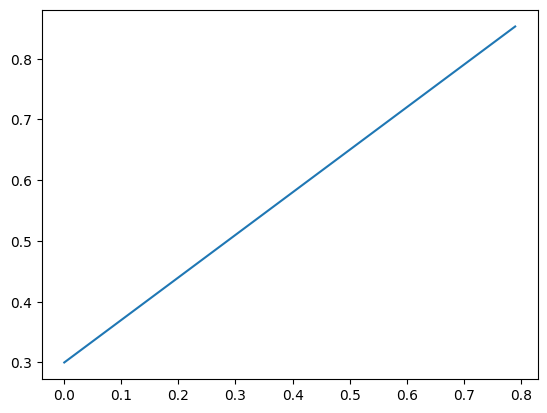

In [56]:
plt.plot(X_train_regression, y_train_regression);

In [57]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [58]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [59]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901


Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05599, Test loss: 0.01426
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


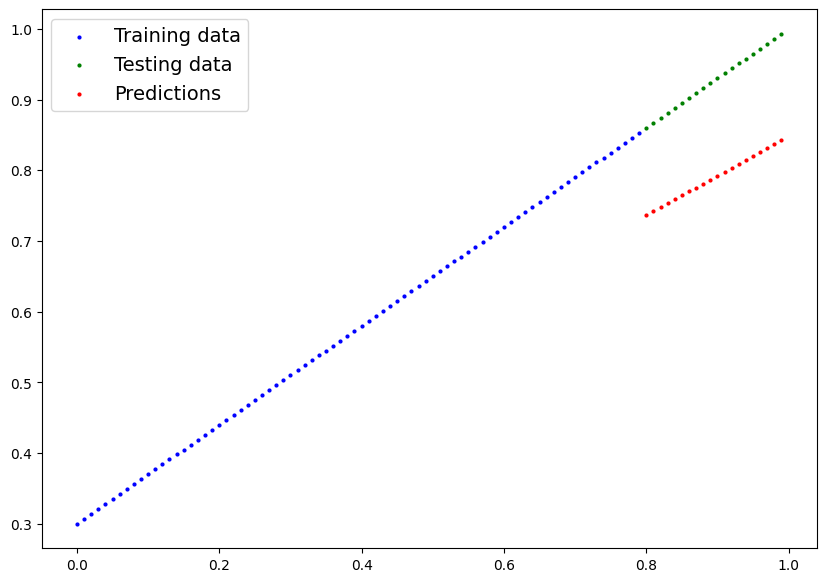

In [60]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());